In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#libraries
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import re
import logging
import time
import polars as pl

#setup
logging.basicConfig(level=logging.INFO)

#group library
from label_legends.preprocess import holdout, transform, load_data
from label_legends.util import CONLL_DIR, ROOT, RESOURCE
from label_legends.preprocess import holdout, transform, load_data, load_test
from label_legends.result import calculate_scores, download_predictions, get_experiment, load_predictions, client, get_current
import json
import mlflow
from mlflow.models import infer_signature
from mlflow.models.model import ModelInfo

c:\Users\noika\Documents\NLP project\label_legends\nlp-ie-label-legends\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def evaluate_baseline(true_labels, predictions, baseline_name):
    
    logging.info(f"Evaluating {baseline_name}...")
    
    #precision, recall, F1(macro avg)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average="binary")
    
    #confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    
    # Print Evaluation Metrics
    print(f"\n{baseline_name} Evaluation Metrics:")
    print(f"Precision (Macro Avg): {precision:.4f}")
    print(f"Recall (Macro Avg): {recall:.4f}")
    print(f"F1 Score (Macro Avg): {f1:.4f}")
    print("\nConfusion Matrix:")
    print(cm)

# Loading the data

In [4]:
#loading the data
logging.info("Loading data...")
load_data().collect()

#transforming the data
val, tra = holdout()
logging.info("Transforming data...")
tra = transform(tra)
val = transform(val)

#loading the test set
logging.info("Loading the test set...")
test = transform(load_test().collect())

#converting 'label' column to integer
logging.info("Converting labels to integers...")
tra = tra.with_columns(
    pl.col("label").cast(pl.Int32)
)
val = val.with_columns(
    pl.col("label").cast(pl.Int32)
)

INFO:root:Loading data...
INFO:root:Transforming data...
c:\Users\noika\Documents\NLP project\label_legends\nlp-ie-label-legends\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
INFO:root:Loading the test set...
INFO:root:Converting labels to integers...


In [5]:
tra

id,text,tokens,token_ids,label
i64,str,list[str],list[i64],i32
26016,"""#VoteDemOut seditionist wanna …","[""#"", ""votedemout"", … ""ven""]","[7, 3000, … 3000]",0
41060,"""Cerno hops from wave to wave: …","[""cerno"", ""hop"", … "".""]","[3000, 3000, … 26]",1
35766,"""think about it.. he´s called J…","[""think"", "".."", … ""elect""]","[2688, 27, … 911]",0
23678,"""Hmm, you could rewrite this wi…","[""hmm"", "","", … ""justsaying""]","[1284, 22, … 3000]",0
52396,"""Every girl in a game, or on si…","[""girl"", ""game"", … "".""]","[1164, 1135, … 26]",0
…,…,…,…,…
6785,"""I just think my dick couldn't …","[""just"", ""think"", … ""..😂😂😂""]","[1482, 2688, … 3000]",0
31355,"""no he deadasss hit the nail on…","[""deadass"", ""hit"", … "".""]","[3000, 1282, … 26]",0
49834,"""Aren't these goblins always wh…","[""goblins"", ""whine"", … ""hastagsarestillcool""]","[3000, 2914, … 3000]",0


In [6]:
#putting the text and label columns into lists
train_texts = tra['text'].to_list()
train_labels = tra['label'].to_list()

val_texts = val['text'].to_list()
val_labels = val['label'].to_list()

test_texts = test['text'].to_list()
test_labels = test['label'].to_list()

# Training the model

In [7]:
#starting the baseline
start_train_time = time.time()

def load_bad_words(file_path):
    """Load bad words from a .txt file, one word per line."""
    with open(file_path, 'r', encoding='utf-8') as file:
        bad_words = [line.strip() for line in file.readlines()]
    return bad_words

In [8]:
#loading the bad words - this will implicate whether a comment is sexist or not
bad_words = load_bad_words(RESOURCE / "compiled_bad_words.txt")
bad_words

#creating a regex pattern to match any bad word
bad_words_pattern = r'\b(' + '|'.join(re.escape(word) for word in bad_words) + r')\b'

#end of training
train_time_regex = time.time() - start_train_time

# Predicting

In [9]:
def classify_with_bad_words(text, pattern):
    """
    returns 1 if the text contains bad words, else 0.
    """
    return 1 if re.search(pattern, text, re.IGNORECASE) else 0

In [10]:
#predicting the labels and timing the test time
start_test_time = time.time()

#predictions for the validation set
test_pred_regex = [classify_with_bad_words(text, bad_words_pattern) for text in test_texts]

test_time_regex = time.time() - start_test_time

# Evaluation

In [11]:
#evaluation
evaluate_baseline(test_labels, test_pred_regex, "Regex Baseline")
print(f"Training Time: {train_time_regex:.4f} seconds")
print(f"Test Time: {test_time_regex:.4f} seconds")

INFO:root:Evaluating Regex Baseline...



Regex Baseline Evaluation Metrics:
Precision (Macro Avg): 0.3414
Recall (Macro Avg): 0.6087
F1 Score (Macro Avg): 0.4375

Confusion Matrix:
[[5228 3657]
 [1219 1896]]
Training Time: 0.1802 seconds
Test Time: 6.3540 seconds


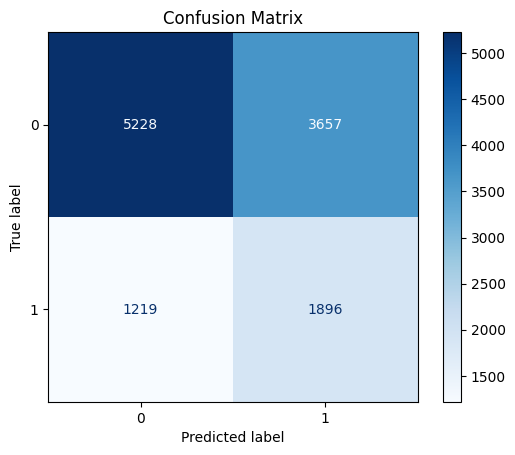

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(test_labels, test_pred_regex)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.savefig(r'../resource/mlflow/Regex/confusion_matrix.png')
plt.show()

In [13]:
scores_regex = calculate_scores(test_labels, test_pred_regex)
print(scores_regex)

precision:	0.3414
recall:		0.6087
fscore:		0.4375
accuracy:	0.5937
tn: 5228	 fp: 3657
fn: 1219	 tp: 1896


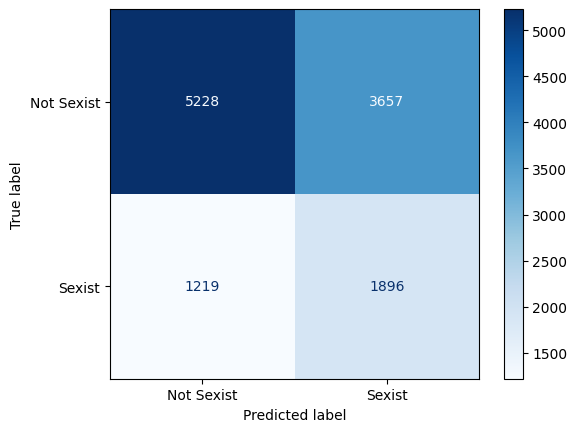

In [14]:
disp = ConfusionMatrixDisplay(confusion_matrix=scores_regex.confusion_matrix(), display_labels=["Not Sexist", "Sexist"]).plot(cmap="Blues")

# Report model to MLflow

In [15]:
with mlflow.start_run(
        experiment_id=get_experiment().experiment_id, 
        run_name="regex testing"
        ):
    mlflow.log_params({"regex_pattern": bad_words_pattern})
    mlflow.log_metrics(scores_regex.asdict())
    mlflow.set_tag("model", "regex")

    mlflow.log_table({"id": test["id"], "prediction": test_pred_regex}, "predictions_regex.json")
    mlflow.log_figure(disp.figure_, "confusion_matrix.png")

    #log the model
    prediction_data = {
        "columns": ["id", "prediction"],
        "data": [[id_, pred] for id_, pred in zip(test["id"], test_pred_regex)]
    }
    # Save to a JSON file
    predictions_file = r"..\\resource\\mlflow\\Regex\\predictions.json"
    with open(predictions_file, "w") as f:
        json.dump(prediction_data, f, indent=4)
        
    # Log the JSON file as an artifact
    mlflow.log_artifact(predictions_file)
        
    # Simulate model registration
    mlflow.set_tag("registered_model_name", "Regex")
    mlflow.set_tag("model_alias", "current")

    # Register the model
    model_uri = f"runs:/{mlflow.active_run().info.run_id}/regex_predictions.json"
    registered_model = mlflow.register_model(model_uri=model_uri, name="Regex") 


client().set_registered_model_alias("Regex", "current", registered_model.version)

2024/12/15 14:52:16 WARNING mlflow.utils.validation: Param value '\b(cockknocker|n1gger|f\ ing|fukker|nympho|fcuking|gook|freex|arschloch|fistfucked|chinc|raunch|fell...' (11121 characters) is truncated to 6000 characters to meet the length limit.
Registered model 'Regex' already exists. Creating a new version of this model...
Created version '5' of model 'Regex'.


# Loading Predictions

In [16]:
get_current("Regex")

<ModelVersion: aliases=['current'], creation_timestamp=1734270736240, current_stage='None', description=None, last_updated_timestamp=1734270736240, name='Regex', run_id='c6ff313033974791967fbb2fc5321987', run_link=None, source='file:///c:/Users/noika/Documents/NLP%20project/label_legends/nlp-ie-label-legends/notebooks/mlruns/293497917933323667/c6ff313033974791967fbb2fc5321987/artifacts/regex_predictions.json', status='READY', status_message=None, tags={}, user_id=None, version=5>

In [17]:
load_predictions("Regex").head()

id,prediction
i64,i64
100,0
10005,1
10006,1
10007,1
10008,1
